In [91]:
import time

import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plot
import seaborn as sn


from sklearn.metrics import mean_absolute_error


from sklearn.model_selection import train_test_split

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# models
import xgboost as xgb

In [92]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pmlprices-raw-data/4property.train.pkl
/kaggle/input/pmlprices-raw-data/4property.test.pkl


In [93]:
train = pd.read_pickle('/kaggle/input/pmlprices-raw-data/4property.train.pkl')
test = pd.read_pickle('/kaggle/input/pmlprices-raw-data/4property.test.pkl') 

In [94]:
# # to pickle4:
# train.to_pickle('4property.train.pkl', protocol=4)
# test.to_pickle('4property.test.pkl', protocol=4)

In [95]:
pd.set_option('max_columns', 100)
pd.set_option('max_info_columns', 500)

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45694 entries, 0 to 45693
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breadcrumbs                 45694 non-null  object 
 1   date                        45694 non-null  object 
 2   geo_block                   45694 non-null  object 
 3   owner                       45694 non-null  object 
 4   price                       45694 non-null  float64
 5   Security:                   26186 non-null  object 
 6   Building type:              45520 non-null  object 
 7   Object type:                45686 non-null  object 
 8   Ad type:                    45686 non-null  object 
 9   Commission agent:           45371 non-null  object 
 10  Construction phase:         35768 non-null  object 
 11  Housing class:              35768 non-null  object 
 12  Elevator:                   26821 non-null  object 
 13  Bathroom type:              123

In [97]:
train.head(100)

,breadcrumbs,date,geo_block,owner,price,Security:,Building type:,Object type:,Ad type:,Commission agent:,Construction phase:,Housing class:,Elevator:,Bathroom type:,Balcony type:,Mortgage possible:,The view from the window:,Garbage chute:,Repair:,Fridge:,Phone:,Furniture:,Free layout:,It is possible to bargain:,Floor covering:,Room type:,Internet:,Kitchen furniture:,TV:,Washing machine:,Foundation type:,Overlap type:,Type of the building:,Playground:,Class:
0,"[Москва, МЦК Лужники]","[23 февраля 2018, 133, (+2 за сегодня), Обновл...","[г. Москва, г. Москва]",[],380.610000,"secure Parking, video surveillance, 24-hour se...",Brick,apartments,new building,no fee,Commissioned,Elite class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Москва, Новая Москва, п. Сосенское, п. Коммун...","[сегодня в 04:52, 3, (+3 за сегодня)]","[Новая Москва, п. Сосенское, п. Коммунарка, Юж...",[],8.004631,Yes,Monolithic-brick,flat,from the developer,no fee,Building walls,Comfort class,yes,separate,balcony,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Москва, МЦК Крымская, ул. Поляны]","[5 марта, 6, (+1 за сегодня), Обновлено 15 мая]","[г. Москва, ул Поляны, г. Москва, ул Поляны]",[],6.520000,provided,Monolithic,apartments,from the developer,no fee,Finish,Comfort class,yes,combined,NaN,NaN,yard,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Москва, Беговой, м. Динамо, МЦК Хорошёво]","[22 мая 2018, 60, (+2 за сегодня), Обновлено 1...","[г. Москва, Беговой, г. Москва, Беговой]",[],20.269686,NaN,Monolithic,flat,new building,no fee,NaN,NaN,yes,NaN,loggia,yes,street,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Москва, Филёвский Парк, м. Фили, МЦК Шелепиха]","[26 декабря 2018, 13, (+1 за сегодня), Обновле...","[г. Москва, Филёвский Парк, г. Москва, Филёвск...",[],15.100880,NaN,Monolithic,apartments,secondary,no fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[Москва, Останкинский, м. Алексеевская, МЦК Ро...","[20 апреля, 7, (+3 за сегодня), Обновлено 17 мая]","[г. Москва, Останкинский, г. Москва, Останкинс...",[],32.146000,NaN,Monolithic,apartments,secondary,no fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,"[Москва, Филёвский Парк, м. Фили, МЦК Шелепиха]","[18 января, 17, (+2 за сегодня), Обновлено 14 ...","[г. Москва, Филёвский Парк, г. Москва, Филёвск...",[],13.950000,NaN,Monolithic,flat,new building,no fee,Building walls,Business class,yes,NaN,loggia,yes,street,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,"[Москва, Хорошёво-Мнёвники, м. Октябрьское пол...","[17 мая, 3, (+2 за сегодня)]","[г. Москва, Хорошёво-Мнёвники, ул Народного Оп...",[],7.900000,provided,Monolithic,apartments,new building,no fee,Commissioned,Business class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,"[Москва, Зябликово, м. Зябликово, МЦК ЗИЛ]","[16 мая, 5, (+1 за сегодня)]","[г. Москва, Зябликово, г. Москва, Зябликово]",[],6.765000,"fenced area, access control system, video surv...",Monolithic,flat,from the developer,no fee,Playground,Comfort class,yes,NaN,NaN,yes,NaN,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# train and test values comparison
for x in train[train.columns[6:]]:
    print(x, '\n', train[x].unique(), '\n')
    print(x, '\n', test[x].unique(), '\n')
    print('='*60)

Building type: 
 ['Brick' 'Monolithic-brick' 'Monolithic' 'Panel' 'Block' nan 'Wooden'
 'Panel-brick' 'Cast stone' 'Stalinist'] 

Building type: 
 ['Monolithic' 'Panel' 'Monolithic-brick' 'Brick' 'Block' nan 'Stalinist'
 'Cast stone' 'Wooden' 'Panel-brick'] 

Object type: 
 ['apartments' 'flat' 'Studio' nan 'penthouse'] 

Object type: 
 ['flat' 'apartments' 'Studio' 'penthouse' nan] 

Ad type: 
 ['new building' 'from the developer' 'secondary' nan] 

Ad type: 
 ['from the developer' 'secondary' 'new building' nan] 

Commission agent: 
 ['no fee' nan] 

Commission agent: 
 ['no fee' nan] 

Construction phase: 
 ['Commissioned' 'Building walls' 'Finish' nan 'Playground' 'Pit' 'Project'
 'Is GK'] 

Construction phase: 
 ['Finish' nan 'Building walls' 'Commissioned' 'Project' 'Playground' 'Pit'
 'Is GK'] 

Housing class: 
 ['Elite class' 'Comfort class' nan 'Business class' 'Economy class'] 

Housing class: 
 ['Comfort class' nan 'Business class' 'Economy class' 'Elite class'] 

Elevator: 

In [99]:
# object type
train['Object type:'].unique()

array(['apartments', 'flat', 'Studio', nan, 'penthouse'], dtype=object)

In [100]:
# building type

train['Building type:'].unique()

array(['Brick', 'Monolithic-brick', 'Monolithic', 'Panel', 'Block', nan,
       'Wooden', 'Panel-brick', 'Cast stone', 'Stalinist'], dtype=object)

In [101]:
# factorize building type by price
b_type_labels_by_mean = train[['Building type:', 'price']].groupby('Building type:').agg('mean').reset_index().sort_values('price')['Building type:'].values
b_type_labels_by_median = train[['Building type:', 'price']].groupby('Building type:').agg('median').reset_index().sort_values('price')['Building type:'].values

b_type_values = [x for x in range(1, len(b_type_labels_by_mean)+1)]

lab_rep_dict_mean = dict(zip(b_type_labels_by_mean, b_type_values))
lab_rep_dict_median = dict(zip(b_type_labels_by_median, b_type_values))

train['Building type:'].replace(lab_rep_dict_mean)

0        7.0
1        8.0
2        5.0
3        5.0
4        5.0
        ... 
45689    1.0
45690    5.0
45691    1.0
45692    5.0
45693    5.0
Name: Building type:, Length: 45694, dtype: float64

In [102]:
# building type factorization check
print(lab_rep_dict_mean)

{'Panel': 1, 'Block': 2, 'Panel-brick': 3, 'Cast stone': 4, 'Monolithic': 5, 'Stalinist': 6, 'Brick': 7, 'Monolithic-brick': 8, 'Wooden': 9}


In [103]:
# security

# train['Security:'].describe()
[str(x) for x in train['Security:'][train['Security:'].notnull()].values]

word_counter = {}
unique_values = []
for word in ' '.join([str(x) for x in train['Security:'][train['Security:'].notnull()].values]).split():
    
    word = word.lower().strip(',')
    
    if word not in word_counter:
        word_counter[word] = 0
        unique_values.append(word)
    word_counter[word.lower()] +=1

list(dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True)))[:30]
# dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))

['provided',
 'area',
 'closed',
 'video',
 'surveillance',
 'concierge',
 'the',
 'fenced',
 'security',
 'system',
 'yes',
 'access',
 'control',
 'clock',
 'round',
 'and',
 'guarded',
 'perimeter',
 'of',
 'barrier',
 'protected',
 'with',
 'around',
 'by',
 'intercom',
 'cameras',
 'well',
 'landscaping',
 'use',
 'small']

In [104]:
# train['security_wrd_cnt'] = df['Security:'].map(lambda x: len(str(x).split()))
# train['security_len'] = df['Security:'].map(lambda x: len(str(x)))

def get_security_len(field):
    try:
        return len(field.strip())
    
    except:
        return None

def get_security_wrd_cnt(field):
    try:
        return len(field.split())
    
    except:
        return None
    
train['Security:'].map(get_security_len)

0        78.0
1         3.0
2         8.0
3         NaN
4         NaN
         ... 
45689     NaN
45690     8.0
45691     NaN
45692     NaN
45693    22.0
Name: Security:, Length: 45694, dtype: float64

In [105]:
# owner

def get_owner(field):
    if len(field) > 0:
        return str(field[0]).strip().lower()
    else:
        return None
    
def get_owner_len(field):
    try:
        return len(field)
    except:
        return None  
    
def get_owner_cnt(field):
    try:
        return len(field.split())
    except:
        return None  

train['owner'].map(get_owner).value_counts().head(40)
# train['owner'].head()

жк "крылья". доп. скидка 5%!      499
квартиры в жк "аквилон park"!     299
район «скандинавия»               289
переделкино ближнее               271
район «испанские кварталы»        206
жк мир митино: тройные скидки     203
жк "румянцево-парк"               200
жк триколор на вднх.              195
квартиры в жк сиреневый парк      137
жк «остафьево»                    136
жк "семеновский парк"             133
жк "life-ботанический сад"        127
город-парк «первый московский»    118
жилой комплекс «летний сад»       117
уникальный жк «onyx deluxe»       110
городской квартал big time.       104
квартиры в жк "лучи"               97
жк «розмарин» - дом построен!      92
клубный дом soho+noho              86
жк «нормандия»                     76
жк "москвичка"                     73
жк «царская площадь».              72
квартиры в жк "фонвизинский"       70
жк"геометрия". скоро заселение     65
жилой квартал lucky                59
topbn.marketing@gmail.com          46
жк кленовые 

In [106]:
# try and print factorization by mean price for clumns 6:...
for col in train.columns[6:]:
    a = [str(x) for x in train[[col, 'price']].fillna(-1).groupby(col).agg('mean').reset_index().sort_values('price')[col].values]
    type_values = [int(x) for x in range(1, len(a)+1)]
    lab_rep_dict_mean = dict(zip(a, type_values))
    print(a)
    print(lab_rep_dict_mean, '\n')

['Panel', 'Block', 'Panel-brick', 'Cast stone', 'Monolithic', 'Stalinist', '-1', 'Brick', 'Monolithic-brick', 'Wooden']
{'Panel': 1, 'Block': 2, 'Panel-brick': 3, 'Cast stone': 4, 'Monolithic': 5, 'Stalinist': 6, '-1': 7, 'Brick': 8, 'Monolithic-brick': 9, 'Wooden': 10} 

['Studio', '-1', 'flat', 'apartments', 'penthouse']
{'Studio': 1, '-1': 2, 'flat': 3, 'apartments': 4, 'penthouse': 5} 

['-1', 'from the developer', 'secondary', 'new building']
{'-1': 1, 'from the developer': 2, 'secondary': 3, 'new building': 4} 

['-1', 'no fee']
{'-1': 1, 'no fee': 2} 

['Pit', 'Playground', 'Building walls', 'Finish', '-1', 'Is GK', 'Project', 'Commissioned']
{'Pit': 1, 'Playground': 2, 'Building walls': 3, 'Finish': 4, '-1': 5, 'Is GK': 6, 'Project': 7, 'Commissioned': 8} 

['Comfort class', 'Economy class', '-1', 'Business class', 'Elite class']
{'Comfort class': 1, 'Economy class': 2, '-1': 3, 'Business class': 4, 'Elite class': 5} 

['yes', '-1']
{'yes': 1, '-1': 2} 

['combined', 'separate'

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


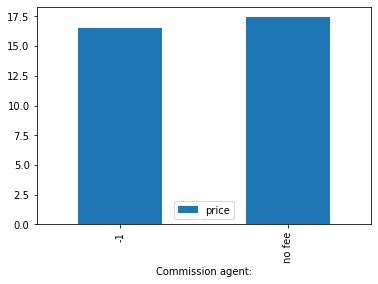

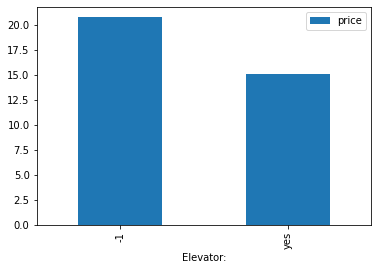

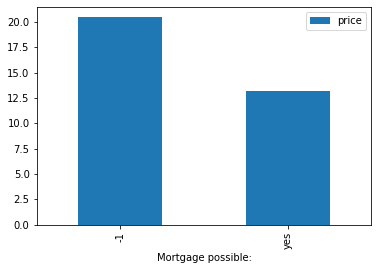

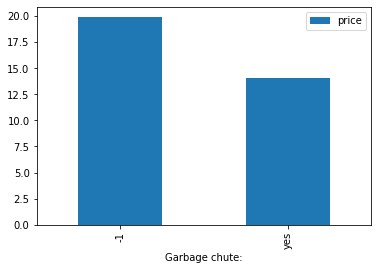

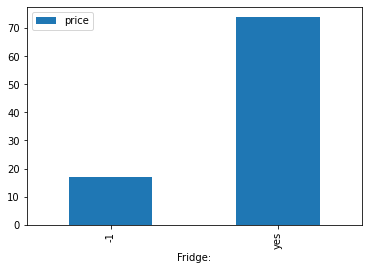

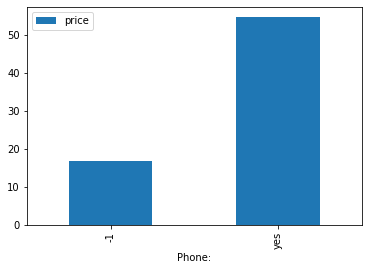

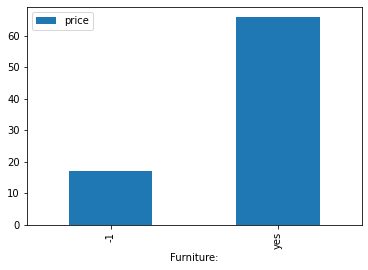

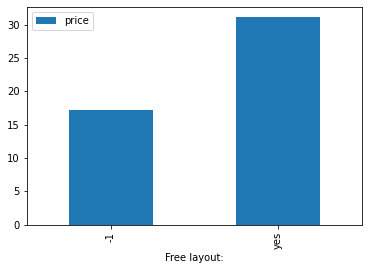

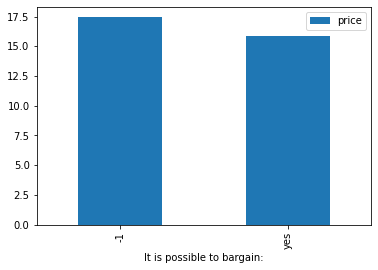

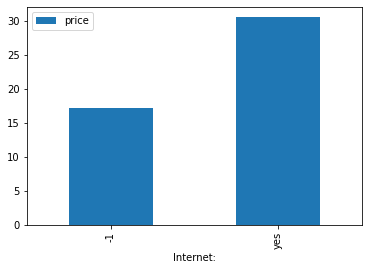

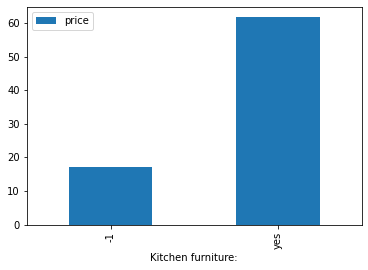

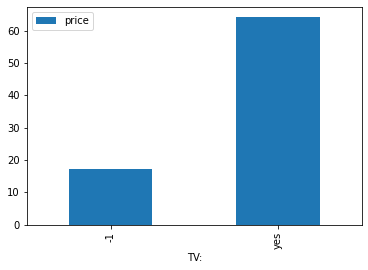

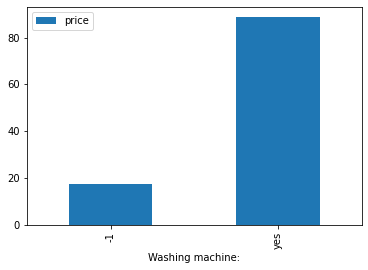

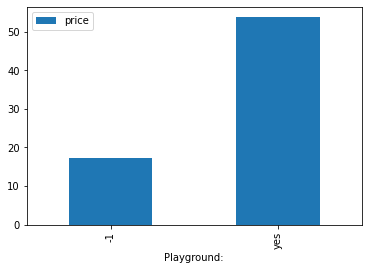

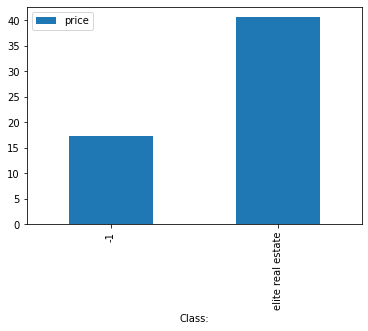

In [107]:
# check mean price for columns 6:... ( with fillna -1)
for col in train[train.columns[6:]]:
    if len(train[col].unique()) <=2:
#         print(col, '\n', train[col].unique(), train[col].count())
        print(train[[col, 'price']].fillna(-1).groupby(col).agg('mean').plot(kind='bar'))
        

In [108]:
train.columns

Index(['breadcrumbs', 'date', 'geo_block', 'owner', 'price', 'Security:',
       'Building type:', 'Object type:', 'Ad type:', 'Commission agent:',
       'Construction phase:', 'Housing class:', 'Elevator:', 'Bathroom type:',
       'Balcony type:', 'Mortgage possible:', 'The view from the window:',
       'Garbage chute:', 'Repair:', 'Fridge:', 'Phone:', 'Furniture:',
       'Free layout:', 'It is possible to bargain:', 'Floor covering:',
       'Room type:', 'Internet:', 'Kitchen furniture:', 'TV:',
       'Washing machine:', 'Foundation type:', 'Overlap type:',
       'Type of the building:', 'Playground:', 'Class:'],
      dtype='object')

### breadcrumps



In [109]:
# count words
word_counter = {}
unique_values = []
for lista in train['breadcrumbs'].values:
    for word in lista:
        if word.lower() not in word_counter:
            word_counter[word.lower()] = 0
            unique_values.append(word.lower())
        word_counter[word.lower()] +=1

list(dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True)))[:50]
dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))

{'москва': 45694,
 'мцк крымская': 7469,
 'новая москва': 6140,
 'мцк кутузовская': 3852,
 'п. сосенское': 3398,
 'мцк шелепиха': 3279,
 'мцк лужники': 3155,
 'мцк коптево': 2327,
 'п. коммунарка': 2314,
 'мцк хорошёво': 2129,
 'южное бутово': 2076,
 'мцк зил': 1954,
 'мцк шоссе энтузиастов': 1803,
 'м. бунинская аллея': 1751,
 'мцк нижегородская': 1731,
 'мцк угрешская': 1643,
 'мцк владыкино': 1568,
 'хорошёво-мнёвники': 1560,
 'мцк ботанический сад': 1507,
 'мцк лихоборы': 1488,
 'ул. дыбенко': 1395,
 'мцк балтийская': 1362,
 'ул. лобачевского': 1344,
 'мцк зорге': 1269,
 'п. московский': 1240,
 'м. выхино': 1207,
 'филёвский парк': 1197,
 'м. октябрьское поле': 1152,
 'мцк ростокино': 1146,
 'тропарёво-никулино': 1115,
 'ховрино': 1101,
 'м. ховрино': 1098,
 'раменки': 1096,
 'м. саларьево': 1010,
 'м. пятницкое шоссе': 931,
 'люблино': 909,
 'ул. верхние поля': 905,
 'м. братиславская': 898,
 'некрасовка': 874,
 'м. рязанский проспект': 847,
 'м. ботанический сад': 827,
 'м. теплы

In [110]:
# prepare sorted list of split words from above
word_counter2={}
for x in [x.split(' ')[0] for x in unique_values if ' ' in x]:
    if x.lower() not in word_counter2:
        word_counter2[x.lower()] = 0
    word_counter2[x.lower()] +=1

print(list(dict(sorted(word_counter2.items(), key=lambda item: item[1], reverse=True))))

['ул.', 'м.', 'пер.', 'п.', 'мцк', 'проезд.', 'пр-кт.', 'д.', 'б-р.', 'ш.', 'сп', 'наб.', 'пл.', 'г.', 'северное', 'мкр.', 'южное', 'чертаново', 'с.', 'аллея.', 'орехово-борисово', 'бирюлёво', 'восточное', 'новая', 'филёвский', 'тёплый', 'рп.', 'марьина', 'проспект', 'западное', 'нагатинский', 'соколиная', 'го', 'х.', 'дп.', 'кв-л.', 'пгт.', 'тер.']


##### date

In [111]:
# day
def get_day(field):
    try:
        day = int(field[0].split()[0])
        return day
    except:
        return None

In [112]:
# month
def get_months(field):
    try:
        month = field[0].split()[1]
        if len(month) < 2:
            return None
        else:
            return month.lower()
    
    except:
        return None

In [113]:
months_ru = list(train['date'].map(get_months).value_counts().index.values)
months_ru

['мая',
 'апреля',
 'марта',
 'февраля',
 'января',
 'октября',
 'декабря',
 'ноября',
 'сентября',
 'августа',
 'июля',
 'июня']

In [114]:
# month translation
months_pl = ['maj', 'kwiecień', 'marzec', 'luty', 'styczeń', 'październik', 'grudzień', 'listopad', 'wrzesień', 'sierpień', 'lipiec', 'czerwiec']

In [115]:
months_k_v = dict(zip(months_ru, months_pl))
months_k_v

{'мая': 'maj',
 'апреля': 'kwiecień',
 'марта': 'marzec',
 'февраля': 'luty',
 'января': 'styczeń',
 'октября': 'październik',
 'декабря': 'grudzień',
 'ноября': 'listopad',
 'сентября': 'wrzesień',
 'августа': 'sierpień',
 'июля': 'lipiec',
 'июня': 'czerwiec'}

In [116]:
train['date'].head(50)
# for x in train['date'].iteritems():
#     print(x)

0     [23 февраля 2018, 133, (+2 за сегодня), Обновл...
1                 [сегодня в 04:52, 3, (+3 за сегодня)]
2       [5 марта, 6, (+1 за сегодня), Обновлено 15 мая]
3     [22 мая 2018, 60, (+2 за сегодня), Обновлено 1...
4     [26 декабря 2018, 13, (+1 за сегодня), Обновле...
5                          [16 мая, 8, (+1 за сегодня)]
6     [13 апреля, 8, (+1 за сегодня), Обновлено 17 мая]
7     [10 февраля, 12, (+1 за сегодня), Обновлено 15...
8                          [14 мая, 6, (+1 за сегодня)]
9      [26 марта, 9, (+3 за сегодня), Обновлено 18 мая]
10       [10 мая, 2, (+1 за сегодня), Обновлено 16 мая]
11        [9 мая, 3, (+1 за сегодня), Обновлено 16 мая]
12    [23 декабря 2018, 24, (+2 за сегодня), Обновле...
13       [10 мая, 2, (+1 за сегодня), Обновлено 16 мая]
14    [17 апреля, 4, (+1 за сегодня), Обновлено 16 мая]
15       [12 мая, 2, (+2 за сегодня), Обновлено 18 мая]
16                [сегодня в 04:55, 2, (+2 за сегодня)]
17                         [16 мая, 5, (+1 за се

In [117]:
# date plus
   
def get_date_plus(field):
    
    if len(field)>2 and field[2][0]=='(':
        lista = list(field[2].split()[0])
#         print(lista)
        int_list = []
        for i in lista:
            try:
                int_list.append(int(i))
                
            except:
                continue
        
        if len(int_list)<2:
            
            return int_list[0]
        
        else:
            strings=[str(integer) for integer in int_list]
            a_string=''.join(strings)
            an_integer=int(a_string)
            
            return an_integer

        

        
# print(date_plus(['12 февраля', '15', '(+12 за сегодня)', 'Обновлено 13 мая']))

train['date'].map(lambda x: x[3] if len(x)>3 else None).value_counts()
# train['date'].map(get_date_plus).value_counts()

Обновлено 15 мая             8868
Обновлено 14 мая             7333
Обновлено 18 мая             5412
Обновлено 17 мая             4557
Обновлено 16 мая             4167
                             ... 
Обновлено 11 апреля             1
Обновлено 15 апреля             1
Обновлено 14 апреля             1
Обновлено вчера в 09:58         1
Обновлено сегодня в 11:10       1
Name: date, Length: 244, dtype: int64

In [118]:
# is updated ?
def get_updated(field):
    
    lista = [int('обновлено' in x.lower()) for x in field]
    
    return int(1 in lista)

# updated(['18 февраля', '14', '(+2 за сегодня)', 'Обновлено 14 мая'])    
train['date'].map(get_updated).head(100)

0     1
1     0
2     1
3     1
4     1
     ..
95    1
96    1
97    0
98    0
99    1
Name: date, Length: 100, dtype: int64

##### geo block

In [119]:
train['geo_block'].head()

0                               [г. Москва, г. Москва]
1    [Новая Москва, п. Сосенское, п. Коммунарка, Юж...
2         [г. Москва, ул Поляны, г. Москва, ул Поляны]
3             [г. Москва, Беговой, г. Москва, Беговой]
4    [г. Москва, Филёвский Парк, г. Москва, Филёвск...
Name: geo_block, dtype: object

In [120]:
train['geo_block'].head(100)

0                                [г. Москва, г. Москва]
1     [Новая Москва, п. Сосенское, п. Коммунарка, Юж...
2          [г. Москва, ул Поляны, г. Москва, ул Поляны]
3              [г. Москва, Беговой, г. Москва, Беговой]
4     [г. Москва, Филёвский Парк, г. Москва, Филёвск...
                            ...                        
95    [г. Москва, Останкинский, г. Москва, Останкинс...
96    [г. Москва, Филёвский Парк, г. Москва, Филёвск...
97    [г. Москва, Хорошёво-Мнёвники, ул Народного Оп...
98         [г. Москва, Зябликово, г. Москва, Зябликово]
99           [г. Москва, Бибирево, г. Москва, Бибирево]
Name: geo_block, Length: 100, dtype: object

In [121]:
# get most popular localizations (up to 200)
geo_dict = {}
unique_values = []
for lista in train['geo_block'].values:
    for word in lista:
        if word.lower() not in geo_dict:
            geo_dict[word.lower()] = 0
            unique_values.append(word.lower())
        geo_dict[word.lower()] +=1

# geo_dict
# sorted(geo_dict.items(), key=lambda item: item[1], reverse=True)[:200]
list(dict(sorted(geo_dict.items(), key=lambda item: item[1], reverse=True)))[:200]

['г. москва',
 'новая москва',
 'п. сосенское',
 'п. коммунарка',
 'южное бутово',
 'хорошёво-мнёвники',
 'ул дыбенко',
 'ул лобачевского',
 'п. московский',
 'филёвский парк',
 'тропарёво-никулино',
 'ховрино',
 'раменки',
 'люблино',
 'ул верхние поля',
 'некрасовка',
 'тёплый стан',
 'кунцево',
 'орехово-борисово южное',
 'г. московский',
 'выхино-жулебино',
 'д. николо-хованское',
 'зябликово',
 'рязанский',
 'п. внуковское',
 'марьино',
 'лефортово',
 'пресненский',
 'пр-кт мира',
 'ул зорге',
 'ул поляны',
 'отрадное',
 'г. зеленоград',
 'свиблово',
 'дмитровский',
 'тимирязевский',
 'бутырский',
 'останкинский',
 'ул берзарина',
 'п. филимонковское',
 'ростокино',
 'солнцево',
 'черёмушки',
 'беговой',
 'головинский',
 'марьина роща',
 'западное дегунино',
 'щукино',
 'митино',
 'ул римского-корсакова',
 'ул золоторожский вал',
 'ул академика павлова',
 'ул генерала белова',
 'хамовники',
 'южное медведково',
 'измайлово',
 'д. румянцево',
 'крылатское',
 'красносельский',
 'дан

In [122]:
# help functions
def get_security_len(field):
    try:
        return len(field.strip())
    
    except:
        return None

def get_security_wrd_cnt(field):
    try:
        return len(field.split())
    
    except:
        return None
    
def get_owner(field):
    if len(field) > 0:
        return str(field[0]).strip().lower()
    else:
        return None
    
def get_owner_len(field):
    try:
        return len(field)
    except:
        return None  
    
def get_owner_cnt(field):
    try:
        return len(field.split())
    except:
        return None  
    
def get_lower(field):
    try:
        return field.lower()
    
    except:
        return None
    
# day
def get_day(field):
    try:
        day = int(field[0].split()[0])
        return day
    except:
        return None
    
# month
def get_months(field):
    try:
        month = field[0].split()[1]
        if len(month) < 2:
            return None
        else:
            return month.lower()
    
    except:
        return None
    
# date plus
def get_date_plus(field):
    
    if len(field)>2 and field[2][0]=='(':
        lista = list(field[2].split()[0])
#         print(lista)
        int_list = []
        for i in lista:
            try:
                int_list.append(int(i))
                
            except:
                continue
        
        if len(int_list)<2:
            
            return int_list[0]
        
        else:
            strings=[str(integer) for integer in int_list]
            a_string=''.join(strings)
            an_integer=int(a_string)
            
            return an_integer
        
# updated ?
def get_updated(field):
    
    lista = [int('обновлено' in x.lower()) for x in field]
    
    return int(1 in lista)


# geoblock
def extract_geoblock(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"geo_block_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}


# size decrease and fillna
def size_decrease(df):

    df=df.fillna(-1)
    int8_max = 127
    int16_max = 32767
    int32_max = 2147483647
    
    for x in df[[col for col in df.columns if col not in['price', 'id']]]:
        if df[x].dtype != 'O':
            
            if df[x].max() <= int8_max:
                df[x]=df[x].astype('int8')
            
            elif df[x].max() <= int16_max:
                df[x]=df[x].astype('int16')
            
            else:
                df[x]=df[x].astype('int32')
                
    return df


In [123]:
# feature enfineering

def long_text_features(train=train, test=test, bread_main_parts=50):
    
    df_all = pd.concat([train, test], axis=0)
    
    df_all['breadcrumbs_w_cnt'] = df_all['breadcrumbs'].map(lambda x: len(x)).astype('int8')
    df_all['breadcrumbs_joined'] = df_all['breadcrumbs'].map(lambda x: ', '.join(x).lower())
    
    # główne człony breadcrumbs
    word_counter = {}
    unique_values = []
    for lista in df_all['breadcrumbs'].values:
        for word in lista:
            
            word = word.lower().strip().strip(',')
            
            if word not in word_counter:
                word_counter[word] = 0
                unique_values.append(word)
            word_counter[word] +=1

    breadcrumbs_main = list(dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True)))[:bread_main_parts]
    for i in breadcrumbs_main:
        df_all['breadcrumbs_' + i] = df_all['breadcrumbs_joined'].map(lambda x: int(i.lower().strip().strip(',') in  x.lower()))
        
    # skróty breadcrumbs
    
    word_counter2={}
    for word in [word.split(' ')[0] for x in unique_values if ' ' in x]:
        
        word = word.lower().strip().strip(',')
        
        if word not in word_counter2:
            word_counter2[word] = 0
        word_counter2[word] +=1

    breadcrumbs_shortcuts = list(dict(sorted(word_counter2.items(), key=lambda item: item[1], reverse=True)))
    
    for i in breadcrumbs_shortcuts:
        df_all['breadcrumbs_' + i] = df_all['breadcrumbs_joined'].map(lambda x: int(i.lower().strip() in  x.lower()))
        
    
    
    # date + factorize month ? wyciągnąć rok ???
    df_all['day'] = df_all['date'].map(get_day)
    
    months_ru = ['мая', 'апреля', 'марта', 'февраля', 'января', 'октября', 'декабря', 'ноября', 'сентября', 'августа', 'июля', 'июня']
    months_pl = ['maj', 'kwiecień', 'marzec', 'luty', 'styczeń', 'październik', 'grudzień', 'listopad', 'wrzesień', 'sierpień', 'lipiec', 'czerwiec']
    months_k_v = dict(zip(months_ru, months_pl))
    
   
    df_all['date_month'] = df_all['date'].map(get_months)
    
    df_all['date_some_number'] = df_all['date'].map(lambda x: x[1])
    df_all['date_plus'] = df_all['date'].map(get_date_plus)
    df_all['date_updated'] = df_all['date'].map(get_updated)
    
    
    
    # geo_block
    df_all['geo_block_cnt'] = df_all['geo_block'].map(lambda x: len(x))
    df_all['geo_block_joined'] = df_all['geo_block'].map(lambda x: ', '.join(x).lower())
    
    geo_dict = {}
    unique_values = []
    for lista in df_all['geo_block'].values:
        for word in lista:
            word = word.lower().strip().strip(',')
            if word.lower() not in geo_dict:
                geo_dict[word.lower()] = 0
                unique_values.append(word.lower())
            geo_dict[word.lower()] +=1


    geo_locations=list(dict(sorted(geo_dict.items(), key=lambda item: item[1], reverse=True)))[:200]

    for i in geo_locations:
        df_all['geo_block_' + i] = df_all['geo_block_joined'].map(lambda x: int(i.lower().strip().strip(',') in x.lower()))
        
    # geo block Vladimira
    
    df_geo_block = df_all["geo_block"].map(extract_geoblock).apply(pd.Series)
    df_all = pd.concat([df_all, df_geo_block], axis=1)

    feats_geo_block = [ x for x in df_geo_block.columns]
    for f in feats_geo_block:
        df_all["{}_cat".format(f)] = df_all[f].factorize()[0]
    
    
    # owner dokończyć !!
    df_all['owner'] = df_all['owner'].map(get_owner)
    df_all['owner_len'] = df_all['owner'].map(get_owner_len)
    df_all['owner_cnt'] = df_all['owner'].map(get_owner_cnt)
    
    
    # security
    df_all['security_wrd_cnt'] = df_all['Security:'].map(get_security_wrd_cnt)
    df_all['security_len'] = df_all['Security:'].map(get_security_len)
    
    word_counter = {}
    unique_values = []
    for word in ' '.join([str(x) for x in df_all['Security:'][df_all['Security:'].notnull()].values]).split():

        word = word.lower().strip().strip(',')
    
        if word not in word_counter:
            word_counter[word] = 0
            unique_values.append(word)
        word_counter[word.lower()] +=1

    security_words=list(dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True)))[:20]
    
    for i in security_words:
        df_all['security_' + i] = df_all['Security:'].map(lambda x: int(i.lower().strip() in str(x).lower()))
    
    return df_all

def short_text_features(df_all, features):
    
    # opracować to , co poniżej!!!!!
    # columns from 6 to end
    created_cols = []
    for col in df_all[features].columns:
        
        df_all[col] = df_all[col].map(get_lower)
        df_all[col] = df_all[col].fillna(-1)
        
        if len(df_all[col].unique()) > 2:
            
    
        
            labels_by_mean = [str(x).lower() for x in df_all[[col, 'price']][False == df_all['price'].isnull()].fillna(-1).groupby(col).agg('mean').reset_index().sort_values('price')[col].values]
            labels_by_median = [str(x).lower() for x in df_all[[col, 'price']][False == df_all['price'].isnull()].fillna(-1).groupby(col).agg('median').reset_index().sort_values('price')[col].values]
        
            type_values = [x for x in range(1, len(labels_by_mean)+1)] # mean or median tu obojętnie
        
            lab_rep_dict_mean = dict(zip(labels_by_mean, type_values))
            lab_rep_dict_median = dict(zip(labels_by_median, type_values))
        
            df_all['fact_{}_mean'.format(col)] = df_all[col].replace(lab_rep_dict_mean)
            df_all['fact_{}_median'.format(col)] = df_all[col].replace(lab_rep_dict_median)
            
            created_cols.append('fact_{}_mean'.format(col))
            created_cols.append('fact_{}_median'.format(col))
        
        else:
            
            df_all = pd.get_dummies(data=df_all, prefix='OH_{}'.format(col), columns=[col])
            
    
    df_all['date_some_number'] = df_all['date_some_number'].astype('int32')
#     df_all['fact_Type of the building:_mean'] = df_all['fact_Type of the building:_mean'].astype('int8')
#     df_all['fact_Type of the building:_median'] = df_all['fact_Type of the building:_median'].astype('int8')                            
    
    # split
    df_train, df_test = df_all[False == df_all['price'].isnull()], df_all[df_all['price'].isnull()]
    
    # size decrease
    df_train = size_decrease(df_train)
    df_test = size_decrease(df_test)
    
    return df_train, df_test.drop(['price'], axis=1)

In [124]:
# read data again
raw_train = pd.read_pickle('/kaggle/input/pmlprices-raw-data/4property.train.pkl')
raw_test = pd.read_pickle('/kaggle/input/pmlprices-raw-data/4property.test.pkl') 


In [125]:
# feature engineering
features = ['Building type:', 'Object type:', 'Ad type:', 'Commission agent:',
       'Construction phase:', 'Housing class:', 'Elevator:',
       'Bathroom type:', 'Balcony type:', 'Mortgage possible:',
       'The view from the window:', 'Garbage chute:', 'Repair:',
       'Fridge:', 'Phone:', 'Furniture:', 'Free layout:',
       'It is possible to bargain:', 'Floor covering:', 'Room type:',
       'Internet:', 'Kitchen furniture:', 'TV:', 'Washing machine:',
       'Foundation type:', 'Overlap type:', 'Type of the building:',
       'Playground:', 'Class:', 'date_month']


start = time.time()
df_all = long_text_features(train=raw_train, test=raw_test, bread_main_parts=50)

train, test = short_text_features(df_all, features)

end = time.time()
print(end - start)

62.94653558731079


In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45694 entries, 0 to 45693
Data columns (total 377 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   breadcrumbs                               45694 non-null  object 
 1   date                                      45694 non-null  object 
 2   geo_block                                 45694 non-null  object 
 3   owner                                     45694 non-null  object 
 4   price                                     45694 non-null  float64
 5   Security:                                 45694 non-null  object 
 6   Building type:                            45694 non-null  object 
 7   Object type:                              45694 non-null  object 
 8   Ad type:                                  45694 non-null  object 
 9   Construction phase:                       45694 non-null  object 
 10  Housing class:                   

In [127]:
# correlation
corrmat = train.corr(method='spearman')


In [128]:
# price zoomed correlation 
k=20
zoomed_correlation = corrmat.nlargest(k, 'price')['price']

zoomed_correlation[(zoomed_correlation > 0.25) | (zoomed_correlation < -0.25)]


price                         1.000000
fact_Housing class:_median    0.361280
fact_Housing class:_mean      0.360097
fact_Building type:_median    0.340800
fact_Building type:_mean      0.340715
geo_block_г. москва           0.285329
Name: price, dtype: float64

In [129]:
# for col in [x for x in test.columns if test[x].dtype != 'O']:
#     if test[col].max() == test[col].min():
#         print(col, '\n', test[col].max(), test[col].min(), '\n')

In [130]:
train.shape

(45694, 377)

In [131]:
test.shape

(22667, 376)

## Model xgboost + hyperopt

In [132]:
# prepare input
black_list=['price', 'id', 'fact_Type of the building:_mean', 'fact_Type of the building:_median']
feats = [z for z in [x for x in train.columns if train[x].dtype != 'O'] if z not in black_list] #tu można też select_dtypes


# prepare X y
X = train[feats].values
y = train["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

target_log = True

if target_log:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [133]:
# hyperopt
# terminated by user, already have params from this cell
def objective(space):
    xgb_params = {
#         'max_depth': int(space['max_depth']),
#         'colsample_bytree': space['colsample_bytree'],
#         'learning_rate': space['learning_rate'],
         'subsample': space['subsample'],
         'random_state': 20, #int(space['random_state']),
         'min_child_weight': int(space['min_child_weight']),
#         'reg_alpha': space['reg_alpha'],
#         'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'tree_method': 'gpu_hist'
    }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if target_log:
        y_pred = np.exp(y_pred)
        y_pred[y_pred < 0] = 1e-6  # for minus zero values

    score = mean_absolute_error(y_test, y_pred)

    return {'loss': score, 'status': STATUS_OK}


space = {
#     'max_depth': hp.quniform('x_max_depth', 2, 20, 1),
#     'colsample_bytree': hp.uniform('x_colsample_bytree', 0.5, 1.),
#     'learning_rate': hp.uniform('x_learning_rate', 0.01, 1),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
#     'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
#     'reg_alpha': hp.loguniform('x_reg_alpha', 0., 1.),
#     'reg_lambda': hp.uniform('x_reg_lambda', 0.7, 1.),
    'n_estimators': hp.quniform ('x_n_estimators', 10, 1000, 10),
}

trials = Trials()
best_params = fmin(fn=objective,
                   space=space,
                   algo=partial(tpe.suggest, n_startup_jobs=40),
                   max_evals=200,
                   trials=trials)

print("The best params: ", best_params)

In [134]:
best_params = {'x_colsample_bytree': 0.7685310716485994, 
'x_learning_rate': 0.010394883215203325, 
'x_max_depth': 19.0, 
'x_reg_alpha': 1.6944816262704712, 
'x_reg_lambda': 0.8665517766185,
'x_min_child_weight': 2.0, 
'x_n_estimators': 220.0, 
'x_subsample': 0.9989396878761256,
'random_state': 20,
}
best_params

{'x_colsample_bytree': 0.7685310716485994,
 'x_learning_rate': 0.010394883215203325,
 'x_max_depth': 19.0,
 'x_reg_alpha': 1.6944816262704712,
 'x_reg_lambda': 0.8665517766185,
 'x_min_child_weight': 2.0,
 'x_n_estimators': 220.0,
 'x_subsample': 0.9989396878761256,
 'random_state': 20}

In [146]:
# prepare X y
X = train[feats].values
y = train["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

target_log = True

shift = 0
if target_log:
    y_train_log = np.log(y_train) + shift
    y_test_log = np.log(y_test) + shift

y_train [  3.41   4.83   7.15   9.91  15.36  47.18 158.34]
[0]	validation_0-rmse:1.96540	validation_0-mae:15.69992	validation_1-rmse:1.96828	validation_1-mae:15.25547
[20]	validation_0-rmse:1.02743	validation_0-mae:12.54792	validation_1-rmse:1.02138	validation_1-mae:12.06068
[40]	validation_0-rmse:0.71595	validation_0-mae:10.25635	validation_1-rmse:0.70881	validation_1-mae:9.73493
[60]	validation_0-rmse:0.56654	validation_0-mae:8.73062	validation_1-rmse:0.55997	validation_1-mae:8.20781
[80]	validation_0-rmse:0.47954	validation_0-mae:7.68214	validation_1-rmse:0.47457	validation_1-mae:7.17915
[100]	validation_0-rmse:0.42412	validation_0-mae:6.95271	validation_1-rmse:0.42106	validation_1-mae:6.46957
[120]	validation_0-rmse:0.38734	validation_0-mae:6.44077	validation_1-rmse:0.38626	validation_1-mae:5.97858
[140]	validation_0-rmse:0.36146	validation_0-mae:6.06823	validation_1-rmse:0.36240	validation_1-mae:5.64410
[160]	validation_0-rmse:0.34306	validation_0-mae:5.79635	validation_1-rmse:0.3

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


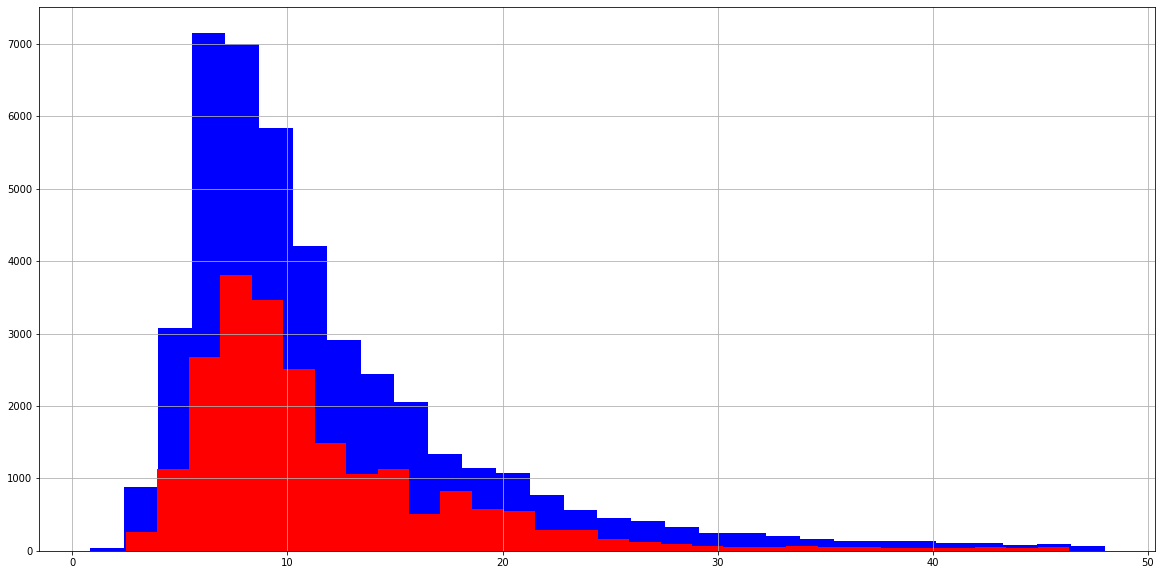

In [147]:
# Model
# kaggle: 4.90

def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
    
    shift = 0
    y_true = np.exp(y_log_true) - shift
    y_pred = np.exp(y_log_pred) - shift
    
    return 'mae', mean_absolute_error(y_true, y_pred)

def fair_obj(y_true, preds):
    labels = y_true
    x = (preds - labels)
    fair_constant = 0.5
    den = abs(x) + fair_constant
    
    grad = fair_constant * x / den
    hess = fair_constant * fair_constant / (den * den)
    
    return grad, hess


print('y_train', np.round(np.percentile(y_train, [1,5,25,50,75,95,99]),2))


xgb_params = {'objective' : fair_obj,
              'colsample_bytree': 0.7685310716485994,
              'learning_rate': 0.010394883215203325,
              'max_depth': 19,
              'reg_alpha': 1.6944816262704712,
              'reg_lambda': 0.8665517766185,
              'min_child_weight': 2,
              'n_estimators': 1300,
              'subsample': 0.9989396878761256,
              'tree_method': 'gpu_hist',
              'random_state': 20}

model = xgb.XGBRegressor(**xgb_params)

eval_set = [(X_train, y_train_log), (X_test, y_test_log)]

model.fit(X_train, y_train_log, \
         eval_metric = mae_log_eval,
         eval_set = eval_set, \
         verbose = 20)


print("predict - NEW METRIC")

if target_log:
    
    y_pred_log = model.predict(X_test) - shift
    y_pred_log[ y_pred_log < 0 ] = 1e-6 # for sub zero values
    y_pred = np.exp( y_pred_log )

score = mean_absolute_error(y_test, y_pred)

print('validation score - NEW OBJ: {}'.format(score))



print("save file")
test_price_log = model.predict(test[feats].values) - shift
test['price'] = np.exp(test_price_log)
test['id'] = test['id'].astype('int32')
test[ ['id', 'price'] ].to_csv('newmetric_3_check.csv', index=False)

plot.figure(figsize = (20,10))
train[ train.price < np.percentile( train.price, 95 ) ]['price'].hist(bins=30, color='blue')
test[ test.price < np.percentile( test.price, 95 ) ]['price'].hist(bins=30, color='red')
plot.show()